# NOTES / TO DO:

* Last: Removed seattle from weather
* Next: Standard Scale Data

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
from time import sleep

import twitter, re, datetime, pandas as pd
import sys
import re
import time
import tweepy
from pprint import pprint 

import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle 
# Custom Imports and scripts
import os, sys
cwd = os.getcwd()
sys.path.append(cwd+'/scripts/')

from importlib import import_module
import_module("my_bigq")
import_module("run_weather")
from my_bigq import bigquery_handler 
import run_weather as rw
import run_twitter as rt

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

In [5]:
# Load Data
q_base_weather = """
SELECT * 
FROM metridaticsmain.webscrapes.weather_data
"""
q_base_twitter = """
SELECT * 
FROM metridaticsmain.webscrapes.twitter_data_raw
"""

# https://googleapis.dev/python/bigquery/latest/usage/pandas.html
df_weather = bigquery_handler(q_base = q_base_weather).run_query(how='selects')
df_twitter_r = bigquery_handler(q_base = q_base_twitter).run_query(how='selects')

In [6]:
# De-dupe and downselect cities
df_weather = df_weather.drop_duplicates(['weather_main', 'weather_description', 'temp_K', 'temp_F',
       'pressure', 'humidity', 'temp_min', 'temp_max', 'sea_level',
       'grnd_level', 'visibility', 'wind_speed', 'wind_deg', 'rain_type',
       'rain_list', 'clouds', 'city_name']).reset_index().drop('index', axis=1)

df_weather=df_weather[df_weather.city_name.apply(lambda x: x in ['Austin', 'Seattle'])].reset_index().drop('index', axis=1)

df_twitter_r = df_twitter_r.drop_duplicates(['tweet_time', 'tweet_text', 'tweet_place']).reset_index().drop('index', axis=1)
df_twitter_r = df_twitter_r[df_twitter_r.tweet_place.isin(['Austin, TX', 'Seattle, WA'])].reset_index().drop('index', axis=1)

In [7]:
# standardize
def city_mapper(x):
    if x == 'Austin, TX':
        return 'Austin'
    if x == 'Seattle, WA':
        return 'Seattle'
    return 'other'

df_weather['is_rain'] = df_weather.weather_main == 'Rain'
df_weather['hour_trunc'] = df_weather.timestamp.dt.floor('h')

df_twitter_r['hour_trunc'] = df_twitter_r.tweet_time.dt.floor('h')
df_twitter_r['city_name'] = df_twitter_r['tweet_place'].apply(lambda x: city_mapper(x))

print('Tweets Found: ', df_twitter_r.shape[0], '. Weather Found: ', df_weather.shape[0])

Tweets Found:  27088 . Weather Found:  567


/home/conor/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


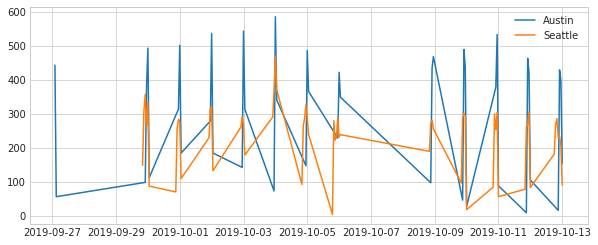

In [8]:
fig, ax = plt.subplots()
fig.set_figwidth(10)

ax.plot(df_twitter_r[df_twitter_r.city_name=='Austin'].groupby(['hour_trunc']).count()['tweet_time'], label='Austin')
ax.plot(df_twitter_r[df_twitter_r.city_name=='Seattle'].groupby(['hour_trunc']).count()['tweet_time'], label='Seattle')

ax.legend()

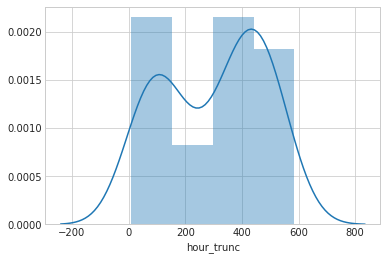

In [9]:
sns.distplot(df_twitter_r[df_twitter_r.city_name=='Austin']['hour_trunc'].value_counts())

# Vectorize Here
Plan:
* Cvec twitter
* Get rolling count - 1 hour, 24 hour
* Join to weather for target class
* Predict!

In [10]:
# vectorize

In [11]:
simple_cvec = CountVectorizer()
twitter_vectorized = simple_cvec.fit_transform(df_twitter_r.tweet_text)
twitter_vectorized = pd.DataFrame(twitter_vectorized.toarray(), columns=simple_cvec.get_feature_names())

good_feats = twitter_vectorized.sum()>10
good_feats = list(good_feats[good_feats].index)
twitter_vectorized = twitter_vectorized.loc[:, good_feats]

twitter_vectorized['tweet_time'] = df_twitter_r['tweet_time']
twitter_vectorized['is_Austin'] = (df_twitter_r['city_name'] == 'Austin')
twitter_vectorized.set_index('tweet_time', inplace=True)

In [12]:
# pickle.dump(simple_cvec, open("info/cvec_simple.sav", 'wb'))
# twitter_vectorized.to_csv('./info/data/twitter_vectorized.csv', index=True)

## Reopen here

In [13]:
simple_cvec = pickle.load(open('info/cvec_simple.sav', 'rb'))

twitter_vectorized = pd.read_csv('./info/data/twitter_vectorized.csv')
twitter_vectorized = twitter_vectorized.set_index(pd.to_datetime(twitter_vectorized.tweet_time)).drop('tweet_time', axis=1)

In [18]:
tv_austin = twitter_vectorized[twitter_vectorized.is_Austin].drop('is_Austin', axis=1)

In [25]:
# simple: From 25 until 2 hours ago
tv_austin_1s = tv_austin.resample("1T").sum().fillna(0)
tv_austin_25h = tv_austin_1s.rolling(window=25*60, min_periods=1).sum()
tv_austin_2h = tv_austin_1s.rolling(window=2*60, min_periods=1).sum()

tv_austin_diff = tv_austin_25h - tv_austin_2h
tv_austin_diff['hour_trunc'] = pd.Series(tv_austin_diff.index, index=tv_austin_diff.index).dt.floor('h')

In [ ]:
df_formodel = tv_austin_diff.join(df_weather[df_weather.city_name=='Austin'].loc[:, ['hour_trunc', 'is_rain']].set_index('hour_trunc'), on='hour_trunc')
df_formodel = df_formodel.reset_index()

In [31]:
np.random.seed(42)

rand_index = list(np.random.choice(df_formodel.shape[0], min(df_formodel.shape[0],75000), replace=False, ))

df_formodel_red = df_formodel.iloc[rand_index, :]
df_formodel_red = df_formodel_red.drop(['tweet_time', 'hour_trunc'], axis=1)

df_formodel_red = df_formodel_red[~df_formodel_red.is_rain.isnull()]

df_formodel_red['is_rain'] = df_formodel_red['is_rain'].astype(int)

In [33]:
df_formodel_boot = pd.concat([
    df_formodel_red,
    df_formodel_red[df_formodel_red.is_rain==1],
    df_formodel_red[df_formodel_red.is_rain==1], 
]).reset_index().drop('index', axis=1)

In [34]:
X = df_formodel_boot.loc[:, [col for col in df_formodel_boot.columns if col != 'is_rain']]
y = df_formodel_boot.is_rain

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LogisticRegression()
lr.fit(X_train, y_train)

/home/conor/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
# pickle.dump(lr, open("new_log_reg_v2.sav", 'wb'))

In [36]:
df_formodel_boot['predicted'] = lr.predict(X)
df_formodel_boot['probas'] = [element[1] for element in lr.predict_proba(X)]

In [42]:
print('Model Predcition Accuracy: {:.2f}'.format(lr.score(X_test, y_test)))
print('Target Class concentration: {:.2f}'.format(y_test.mean()))

Model Predcition Accuracy: 0.89
Target Class concentration: 0.23


In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
best_score = 0
for n_estimators in [250, 300]:
    for max_depth in [200, None]:
        for min_samples_split in [ 2, 3]:
            rf = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators , max_depth=max_depth, min_samples_split=min_samples_split)
            rf.fit(X_train, y_train)
            this_score = rf.score(X_test, y_test)
            if this_score >  best_score:
                best_configs = {'score':this_score, 'estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
                best_score = this_score
#             print('Score: {:.0%}, n_estimators {}, max_depth {}, min_split {}'.format(rf.score(X_test, y_test), n_estimators, max_depth,min_samples_split ))

In [48]:
print('Random Forest Best score: {:.2f}'.format(best_score))

Random Forest Best score: 0.89


In [49]:
print('Model Predcition Accuracy: {:.2f}'.format(rf.score(X_test, y_test)))
print('Target Class concentration: {:.2f}'.format(y_test.mean()))

Model Predcition Accuracy: 0.89
Target Class concentration: 0.23


In [184]:
# df_formodel_red['predicted'] = rf.predict(X)
# df_formodel_red['probas'] = [element[1] for element in rf.predict_proba(X)]


## Select Model Here

In [50]:
chosen_model = lr
orig_data = df_formodel_red.loc[:,[col for col in df_formodel_red.columns if col not in ['is_rain', 'predicted', 'probas']] ]
df_formodel_red['predicted'] = chosen_model.predict(orig_data)
df_formodel_red['probas'] = [element[1] for element in chosen_model.predict_proba(orig_data)]

df_results = df_formodel_red.loc[:, ['is_rain', 'probas', 'predicted']]

In [51]:
df_results.groupby(['is_rain']).mean()

,probas,predicted
is_rain,,
0,0.107537,0.098115
1,0.660741,0.840000


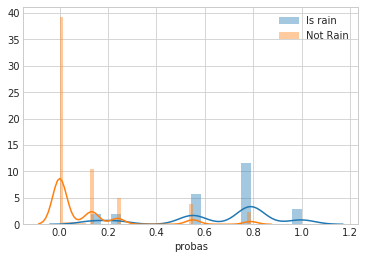

In [52]:
fig, ax = plt.subplots()
sns.distplot(df_results[df_results.is_rain==1]['probas'], ax=ax, label='Is rain')
sns.distplot(df_results[df_results.is_rain==0]['probas'], ax=ax, label='Not Rain')
# ax.set_ylim((0,5))
ax.legend()

In [53]:
def correct_grid(guess, actual):
    if guess == 0:
        if actual ==0:
            return 'true negative'
        else:
            return 'false negative'
    if guess == 1:
        if actual ==1:
            return 'true positive'
        else:
            return 'false positive'

In [ ]:
list_of_blends = []
# blend = {'true negative':, 'true positive':, 'false negative':, 'falst positive':}
for threshold in [x/100 for x in range(1,55, 2)]:
    df_results['predicted_improved'] = df_results.probas.apply(lambda x: 1 if x >threshold else 0)
    
    _results = df_results.apply(lambda x: correct_grid(x['predicted_improved'], x['is_rain']), axis=1)
    _results_vals = _results.value_counts()
    try:
        false_pos = _results_vals.loc['false positive']
    except:
        false_pos = 0
    try:
        false_neg = _results_vals.loc['false negative']
    except:
        false_neg = 0
    list_of_blends.append({
        'threshold': threshold,
        'true negative':  _results_vals.loc['true negative'], 
        'true positive':  _results_vals.loc['true positive'],
        'false negative': false_neg, 
        'false positive': false_pos
    })

df_blends = pd.DataFrame(list_of_blends)

df_blends['tp_fp'] = df_blends['true positive'] / (df_blends['false positive'] + df_blends['true positive'] )
df_blends['tp_f'] = df_blends['true positive'] / (df_blends['false positive'] + df_blends['false negative'] )

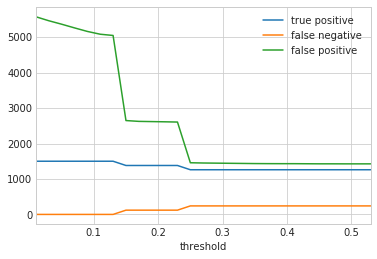

In [58]:
df_blends.set_index('threshold').loc[:, ['true positive', 'false negative', 'false positive']].plot()

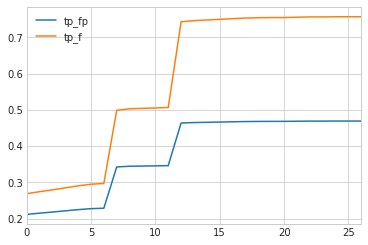

In [61]:
fig, ax = plt.subplots()
df_blends.tp_fp.plot(ax=ax)
df_blends.tp_f.plot(ax=ax)

ax.legend()

In [62]:
df_blends

,threshold,true negative,true positive,false negative,false positive,tp_fp,tp_f
0,0.01,8959,1500,0,5575,0.212014,0.269058
1,0.03,9071,1500,0,5463,0.215424,0.274574
2,0.05,9169,1500,0,5365,0.218500,0.279590
3,0.07,9273,1500,0,5261,0.221861,0.285117
4,0.09,9373,1500,0,5161,0.225191,0.290641
5,0.11,9452,1500,0,5082,0.227894,0.295159
6,0.13,9487,1500,0,5047,0.229113,0.297206
7,0.15,11887,1380,120,2647,0.342687,0.498735
8,0.17,11910,1380,120,2624,0.344655,0.502915
9,0.19,11916,1380,120,2618,0.345173,0.504018


How this seems now is that 39% proba should be 51% and a guess for rain. So, need to add .12 to everything to get proba effective

In [63]:
df_results['probas_improved'] = df_results.probas.apply(lambda x: min([x+0, .99]))
df_results['predicted_improved'] = df_results.probas_improved.apply(lambda x: 1 if x >.5 else 0)
tp_rate = df_results.groupby(['is_rain']).mean().loc[1, 'predicted_improved']
fp_rate = df_results.groupby(['is_rain']).mean().loc[0, 'predicted_improved']

fn_rate = (1 - df_results.groupby(['is_rain']).mean().loc[1, 'predicted_improved'])
tn_rate = (1 - df_results.groupby(['is_rain']).mean().loc[0, 'predicted_improved'])

In [64]:
df_results.groupby(['is_rain']).mean()

,probas,predicted,predicted_improved,probas_improved
is_rain,,,,
0,0.107537,0.098115,0.098115,0.107537
1,0.660741,0.840000,0.840000,0.659670


# When I say it's raining, is it raining 51% of the time?

In [65]:
num_rains = (df_formodel.is_rain==1).sum()
num_not_rains = (df_formodel.is_rain==0).sum()

count_tp = num_rains * tp_rate
count_fp = num_not_rains * fp_rate

print('Is raining, state raining: {:.0%}'.format(count_tp / (count_tp + count_fp)))
print('Is raining, state not: {:.0%}'.format(fn_rate))

Is raining, state raining: 47%
Is raining, state not: 16%


In [66]:
df_results.head()

,is_rain,probas,predicted,predicted_improved,probas_improved
8790,0,1.522321e-13,0,0,1.522321e-13
13980,0,3.776987e-07,0,0,3.776987e-07
21461,0,7.896761e-01,1,1,7.896761e-01
8341,0,3.570807e-09,0,0,3.570807e-09
10801,0,5.079530e-08,0,0,5.079530e-08
